## Import libraries

In [472]:
import numpy as np
import pandas as pd
import re
from thefuzz import fuzz
import spacy
from spacy import displacy
from thefuzz import process
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Functions used in this Program

### Fx to Generalise the roles using The Fuzz Package

fuzz_roles(string)

string : text dt : str

### Fx to Extract Skills from job Description using NER Spacy Model 

skill_extract(df,subset)

1. df : Data Frame dt: Pandas
2. subset : Column name(Role type) dt : str
3. return : Dictionary

### Fx for Data/Technology Skills for Role parsing
 
role_skill_extract(df,role_new)

1. df : Data Frame dt: Pandas
2. role_new : Column name(Role type) dt : str
3. return : Data Frame

### Fx To Plot Skills

count_plot(df,subset,name,skill_type,top_n)

1. df : Data Frame - dt :pandas
2. subset : column we want to subset - dt : str
3. role : role to be printed on the title - dt : str
4. skill : skill to be printed on the title - dt : str
5. top_skills : top number of skills we want to see - dt : int


### Soft Skills Parsing

role_soft_extract(df,role_soft)

1. df : Data Frame dt: Pandas
2. role_soft : Column name(Role type) dt : str
3. return : Data Frame

### Salary Parsing

salary_preprocessing(df,subset)

1. df : Data Frame dt: Pandas
2. subset : Column name(Role type) dt : str
3. return : Data Frame


## Collect all Scrapped Data

In [426]:
get_cd = os.getcwd()

In [427]:
df_list = []

# Loop through the files in the folder
for filename in os.listdir(get_cd):
    if filename.endswith(".csv"):  
        # Read the CSV file into a DataFrame
        df = pd.read_csv(filename)  # No need to join path since it's in the same folder
        
        # Append the DataFrame to the list
        df_list.append(df)

# Concatenate all DataFrames in the list
concatenated_df = pd.concat(df_list, ignore_index=True)

# Now, concatenated_df contains data from all the CSV files
concatenated_df.head()

,Job Title,Company,Location,Salary,Description,Link
0,Imaging Analyst - Biotech,Momentum Staffing Group LLC,"Seattle, WA 98101",Not Available,Profile insightsFind out how your skills align...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,Data Analyst,Snappyhires,"Snappyhires in Jackson, MS 39202",$65 - $70 an hour - Contract,Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=fce63a0b5d92c...
2,Data Analyst,Booz Allen,"Eglin AFB, FL","$75,600 - $172,000 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=f35c28faef4c8...
3,Data Analyst,MindPetal Software Solutions,"200 Constitution Avenue NW, Washington, DC 20210","$93,376.88 - $112,453.88 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=7f13d27f85edd...
4,"Sr. Analyst, Data Analytics & Business Intelli...",Comcast Corporation,"Philadelphia, PA 19103","$62,698.24 - $146,949.00 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=ad7edd0cd0b0a...


In [428]:
concatenated_df.shape

(3803, 6)

In [429]:
concatenated_df.isna().sum()

Job Title        0
Company          0
Location         0
Salary           0
Description      0
Link           824
dtype: int64

In [430]:
concatenated_df.columns

Index(['Job Title', 'Company', 'Location', 'Salary', 'Description', 'Link'], dtype='object')

In [431]:
concatenated_df = concatenated_df.drop_duplicates(['Job Title', 'Company', 'Location', 'Salary'])
concatenated_df.shape

(1940, 6)

In [433]:
job_descriptions = concatenated_df[['Description']]

In [434]:
job_descriptions['len_count'] = job_descriptions['Description'].apply(len)

C:\Users\Karthi\AppData\Local\Temp\ipykernel_15368\2660022087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_descriptions['len_count'] = job_descriptions['Description'].apply(len)


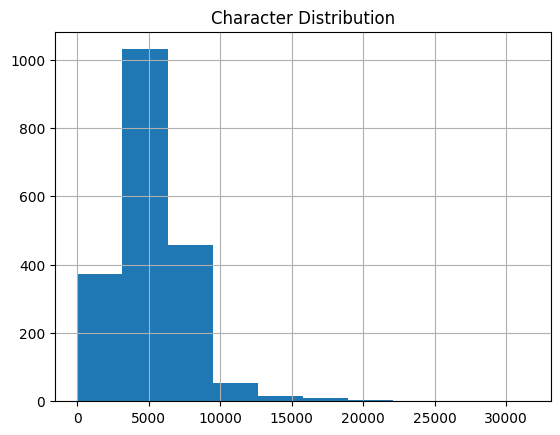

In [504]:
job_descriptions['len_count'].hist()
plt.title('Character Distribution')
plt.show()

### Cleaning Raw Text

In [30]:
#removing \n from text
job_descriptions['Description'] = job_descriptions['Description'].str.replace(r'\n+', ' ', regex=True) 

C:\Users\Karthi\AppData\Local\Temp\ipykernel_15368\2341930899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_descriptions['Description'] = job_descriptions['Description'].str.replace(r'\n+', ' ', regex=True)


Sample for Annotations

In [34]:
#train = job_descriptions['Description'].sample(frac = 0.1)
#train[10:40].to_csv('output2.txt', sep='\t', index=False)
#separator = '|'

# Concatenate all rows with the separator and save to a text file
#with open('output2.txt', 'w', encoding='utf-8') as file:
#    file.write(separator.join(train[10:40]))

In [436]:
# Generalize the roles
roles = pd.Series(['Analyst','Scientist','Machine Learning','Engineer','Big Data','AI'])

### Fx to Generalise the roles using The Fuzz Package

In [437]:
def fuzz_roles(string):
    out = process.extract(string,roles,limit = 1)
    role = out[0][0]
    return role

In [438]:
concatenated_df['Roles'] = concatenated_df['Job Title'].apply(fuzz_roles)

In [439]:
concatenated_df.columns 

Index(['Job Title', 'Company', 'Location', 'Salary', 'Description', 'Link',
       'Roles'],
      dtype='object')

In [440]:
concatenated_df = concatenated_df[['Job Title','Roles', 'Company', 'Location', 'Salary', 'Description', 'Link']]

In [505]:
concatenated_df.tail()

,Job Title,Roles,Company,Location,Salary,Description,Link
3784,Machine Learning Specialist I/II,Machine Learning,Florida Gulf Coast University,"10501 Fgcu Blvd S, Fort Myers, FL 33965",Full-time,Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=c1c923ad6c7b4...
3787,Machine Learning Engineer II - Earner Incentives,Machine Learning,Uber,"Sunnyvale, CA","$158,000 - $175,500 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=e4e1eb765e553...
3796,Business Intelligence & Analytics Manager,Analyst,Elevate ENT Partners,"Houston, TX 77064",Full-time,Profile insightsFind out how your skills align...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3797,Artificial Intelligence and Machine Learning E...,Machine Learning,Booz Allen,"King George, VA","$96,600 - $220,000 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=0f09d0fade073...
3802,Research Scientist,Scientist,University of North Carolina at Chapel Hill,"Chapel Hill, NC 27599","$95,000 - $128,000 a year - Full-time",Profile insightsFind out how your skills align...,https://www.indeed.com/rc/clk?jk=150b5f1d7c1c9...


In [442]:
concatenated_df['Roles'].value_counts()

Analyst             991
Scientist           489
Machine Learning    207
Engineer            138
AI                   62
Big Data             53
Name: Roles, dtype: int64

In [535]:
concatenated_df_1 = concatenated_df

In [553]:
def group(x):
    if x == 'AI':
        return('Machine Learning')
    elif x == 'Big Data':
        return("Engineer")
    elif x == 'Engineer ':
        return("Engineer")
    else:
        return(x)

In [554]:
concatenated_df['Roles'] = concatenated_df['Roles'].apply(group)

In [556]:
concatenated_df['Roles'].value_counts()

Analyst             991
Scientist           489
Machine Learning    269
Engineer            191
Name: Roles, dtype: int64

## NER Spacy Model Load created from Annotated text training

In [443]:
nlp_job_ner = spacy.load("D:\spacy\Model_set2\model-best")

In [444]:
doc = nlp_job_ner("Profile insightsFind out how your skills align with the job descriptionSkillsDo you have experience in SAP ERP?YesNoEducationDo you have a Bachelor's degree?YesNo&nbsp;Job detailsHere’s how the job details align with your profile.Job typeFull-time&nbsp;LocationTallassee, AL 36078&nbsp;Full job description\n\nPosition Summary\n\nAs the Senior Enterprise Data Practice Manager, you will establish and maintain the data & analytics practice and associated services across the Neptune business to empower decision-makers, data stewards, data scientists, and business analysts to make data-driven decisions. You will be responsible for managing Neptune’s data throughout its lifecycle, including data integration, quality, governance, and security. You will support project delivery teams in their effort to adopt and execute on data management processes and identify and implement information quality tools for enterprise-wide access.\n\nResponsibilities:\n\nCreate and enforce policies for effective data management\nLead and develop a team of data analysts\nFormulate techniques for quality data collection to ensure adequacy, accuracy and legitimacy of data\nDevise and implement efficient and secure procedures for data handling and analysis with attention to all technical aspects\nWork closely with internal teams, Sales, PMO, Finance, Services, Marketing and the SW Teams to ensure alignment between customer expectations for both product and service offerings\nAct as a trusted advisor to your internal customers, understanding their unique business challenges and requirements\nPresent tailored solutions that align with your customers strategic objectives, effectively demonstrating the value proposition of our data and analytics services\nEstablish rules and procedures for data sharing with upper management, external stakeholders etc.\nSupport others in the daily use of data systems and ensure adherence to legal and company standards\nAssist with reports and data extraction when needed\nMonitor and analyze information and data systems and evaluate their performance to discover ways of enhancing them (new technologies, upgrades etc.)\nEnsure digital databases and archives are protected from security breaches and data losses\nTroubleshoot data-related problems and authorize maintenance or modifications\n\nRequirements:\n\n7-10+ years of relevant experience as a data practice manager or proven experience as a Data Scientist with the leadership experience\nExcellent understanding of data administration and management functions (collection, analysis, distribution, etc.)\nFamiliarity with modern database and information system technologies\nSuperb communication and team-building skills\nPragmatic problem solving and decision-making skills with excellent written and verbal communications\nRelentless passion and commitment to operational excellence – delivering in scope, on time, and on budget to the delight of our internal customers\nExperience with QAD and/or SAP ERP Preferred\nExperience with Azure or AWS Cloud Preferred\nPower BI Certification Preferred\n\nEducation:\n\nBachelor's degree in business, computer science, or a related field of study, or equivalent experience\nAny Cloud DB Certification\n\nLocation: Tallassee, Alabama or Duluth, Georgia\n Physical Requirements: Sedentary Work - Exerting up to 10 pounds of force occasionally and/or a negligible amount of force frequently or constantly to lift, carry, push, pull, or otherwise move objects. Working Conditions: Generally agreeable working conditions such as those found inside offices or equivalent work areas for more than 70% of the time.\n#HP1\n\nEqual Opportunity Employer/Protected Veterans/Individuals with Disabilities\nThe contractor will not discharge or in any other manner discriminate against employees or applicants because they have inquired about, discussed, or disclosed their own pay or the pay of another employee or applicant. However, employees who have access to the compensation information of other employees or applicants as a part of their essential job functions cannot disclose the pay of other employees or applicants to individuals who do not otherwise have access to compensation information, unless the disclosure is (a) in response to a formal complaint or charge, (b) in furtherance of an investigation, proceeding, hearing, or action, including an investigation conducted by the employer, or (c) consistent with the contractor’s legal duty to furnish information. 41 CFR 60-1.35(c)\n&nbsp;")

#### Sample

In [446]:
displacy.render(doc,style='ent')

In [510]:
# Function to return the count of entities for each text
def fx(text):
    doc = nlp_job_ner(text)
    return len(doc.ents)  # Return the number of entities

# Apply the function and sum the counts
count = concatenated_df['Description'].apply(fx)
total_entity_count = count.sum()

print(total_entity_count)


53530


### Fx to Extract Skills from job Description using NER Spacy Model 

In [447]:
def skill_extract(df,subset):
    df = df[df['Roles'] == subset]
    SKILLS = []
    DATA_TOOLS = []
    EDUCATION = []
    EXPERIENCE = []
    SOFT_SKILLS = []
    DOMAIN = []
    RESPONSIBILITY = []
    CERTIFICATE = []
    SALARY = []
    OTHERS = []
    dic_extract = {}
    for text in df['Description']:
        doc = nlp_job_ner(text)
        for ent in doc.ents:
            if ent.label_ == 'SKILLS':
                SKILLS.append(ent.text)
            elif ent.label_ == 'DATA TOOLS':
                DATA_TOOLS.append(ent.text)
            elif ent.label_ == 'EDUCATION':
                EDUCATION.append(ent.text)
            elif ent.label_ == 'EXPERIENCE':
                EXPERIENCE.append(ent.text)
            elif ent.label_ == 'SOFT-SKILLS':
                SOFT_SKILLS.append(ent.text)
            elif ent.label_ == 'DOMAIN':
                DOMAIN.append(ent.text)
            elif ent.label_ == 'RESPONSIBILITY':
                RESPONSIBILITY.append(ent.text)
            elif ent.label_ == 'CERTIFICATE':
                CERTIFICATE.append(ent.text)
            elif ent.label_ == 'SALARY':
                SALARY.append(ent.text)
            else:
                OTHERS.append(ent.text)
                
    dic_extract = {
            'SKILLS': SKILLS,
            'DATA_TOOLS':DATA_TOOLS,
            'EDUCATION':EDUCATION,
            'EXPERIENCE':EXPERIENCE,
            'SOFT_SKILLS':SOFT_SKILLS,
            'DOMAIN':DOMAIN,
            'RESPONSIBILITY':RESPONSIBILITY,
            'CERTIFICATE':CERTIFICATE,
            'SALARY':SALARY,
            'OTHERS':OTHERS
        }
    return dic_extract

## Role Extraction using Model

# Analyst

In [448]:
analyst_skill = skill_extract(concatenated_df,'Analyst')

In [501]:
print(f"Total Skills Identified by Model(SKILL): {len(analyst_skill['SKILLS'])}")
print(f"Total Skills Identified by Model(SOFT SKILL): {len(analyst_skill['SOFT_SKILLS'])}")

Total Skills Identified by Model(SKILL): 16330
Total Skills Identified by Model(SOFT SKILL): 636


In [449]:
analyst = pd.DataFrame(analyst_skill['SKILLS'],columns=['skill'])
analyst['skill'] = analyst['skill'].apply(lambda x: x.lower().strip())

In [451]:
skill_list = ['database','power bi','tableau','excel','sql','python','data']

def fuzz_skills(string):
    out = process.extract(string,skill_list,limit = 1)
    if out[0][1] >= 80:
        return out[0][0]
    else:
        return string


In [452]:
analyst['fuzzy_skill'] = analyst['skill'].apply(fuzz_skills)

### Fx for Data/Technology Skills for Role parsing

In [463]:
def role_skill_extract(df,role_new):
    def fuzz_skills(string):
        out = process.extract(string,skill_list,limit = 1)
        if out[0][1] >= 80:
            return out[0][0]
        else:
            return string
    analyst_skill = skill_extract(df,role_new)
    analyst = pd.DataFrame(analyst_skill['SKILLS'],columns=['skill'])
    analyst['skill'] = analyst['skill'].apply(lambda x: x.lower().strip())
    skill_list = ['database','power bi','tableau','excel','sql','python','data']    
    analyst['fuzzy_skill'] = analyst['skill'].apply(fuzz_skills)
    return analyst

In [453]:
analyst_skills = analyst[analyst['fuzzy_skill'] != 'data']

### Fx To Plot Skills

In [454]:
def count_plot(df,subset,name,skill_type,top_n):
    plt.figure(figsize=(12, 6))
    top_15 = df[subset].value_counts().index[0:top_n]
    df_top = df[df[subset].isin(top_15)]
    order = df_top[subset].value_counts(sort=True).index
    sns.countplot(data = df_top , y = subset,hue = subset,order= order)
    plt.title(f'Top {top_n} {skill_type} Skills For {name}')
    plt.xlabel('Total Number of Skills')
    plt.ylabel('Skill Set')
    plot = plt.show()
    return plot

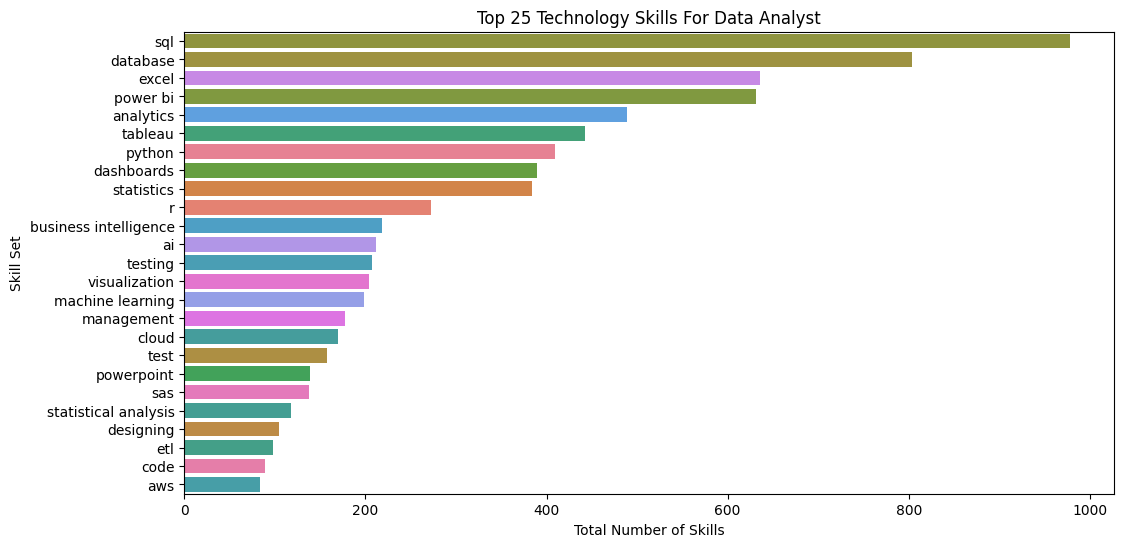

In [593]:
count_plot(analyst_skills,'fuzzy_skill','Data Analyst','Technology',25)

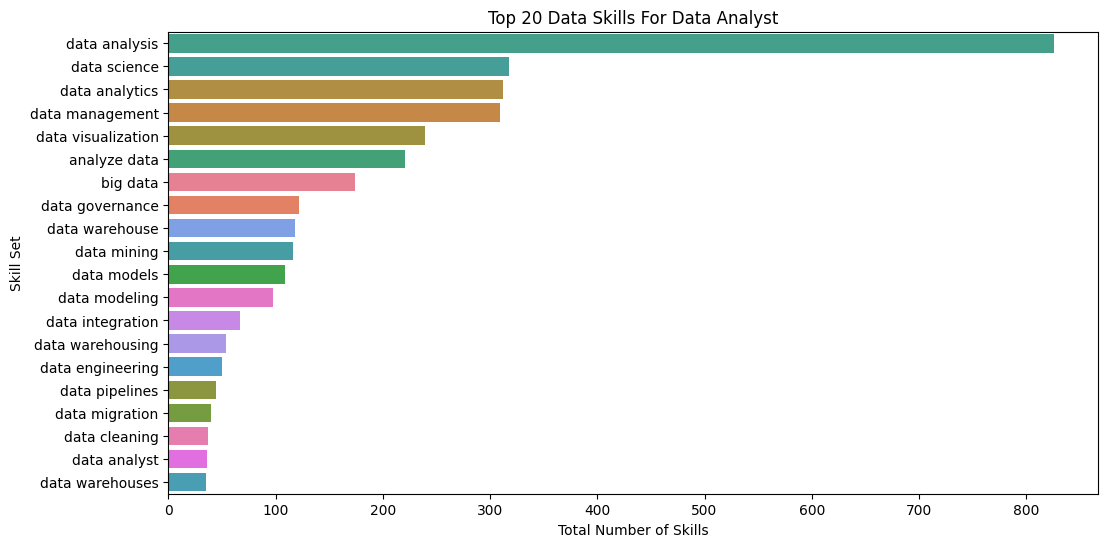

In [456]:
analyst_skills_data = analyst[analyst['fuzzy_skill'] == 'data']
count_plot(analyst_skills_data,'skill','Data Analyst','Data',20)

In [464]:
df_skill = role_skill_extract(concatenated_df,'Analyst')


## Analyst Data Skills

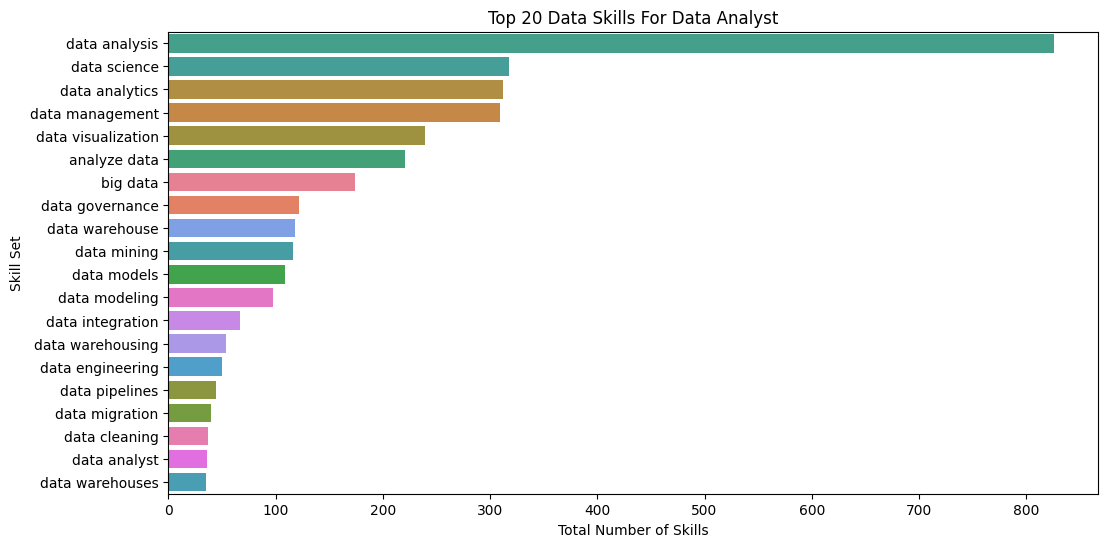

In [466]:
df_skill_data = df_skill[df_skill['fuzzy_skill'] == 'data']
count_plot(df_skill_data,'skill','Data Analyst','Data',20)

### Analyst Technology Skills

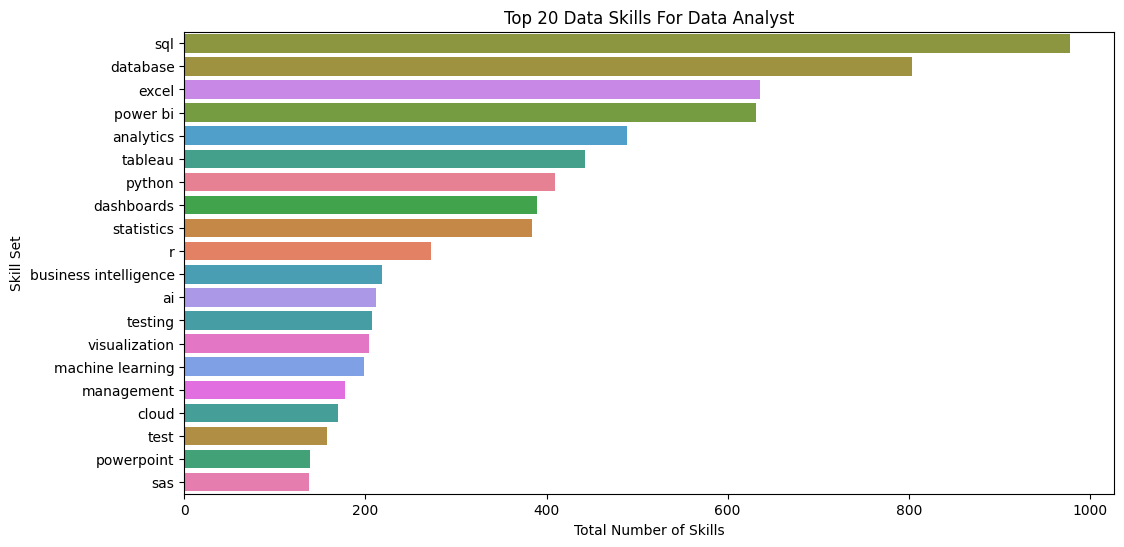

In [468]:
df_skill_data = df_skill[df_skill['fuzzy_skill'] != 'data']
count_plot(df_skill_data,'fuzzy_skill','Data Analyst','Data',20)

In [457]:
analyst_soft = pd.DataFrame(analyst_skill['SOFT_SKILLS'],columns=['soft_skill'])
analyst_soft['soft_skill'] = analyst_soft['soft_skill'].apply(lambda x: x.lower().strip())

In [458]:
soft_skill_list = ['communication','problem solver']

def fuzz_soft_skills(string):
    out = process.extract(string,soft_skill_list,limit = 1)
    if out[0][1] >= 80:
        return out[0][0]
    else:
        return string

In [459]:
analyst_soft['fuzz_ss'] = analyst_soft['soft_skill'].apply(fuzz_soft_skills)

## Soft Skills Parsing

In [471]:
def role_soft_extract(df,role_soft):
    def fuzz_soft_skills(string):
        out = process.extract(string,soft_skill_list,limit = 1)
        if out[0][1] >= 80:
            return out[0][0]
        else:
            return string
    analyst_skill = skill_extract(df,role_soft)
    analyst_soft = pd.DataFrame(analyst_skill['SOFT_SKILLS'],columns=['soft_skill'])
    analyst_soft['soft_skill'] = analyst_soft['soft_skill'].apply(lambda x: x.lower().strip())
    soft_skill_list = ['communication','problem solver']
    analyst_soft['fuzz_ss'] = analyst_soft['soft_skill'].apply(fuzz_soft_skills)
    return analyst_soft

## Soft Skills

In [473]:
df_analyst_ss = role_soft_extract(concatenated_df,'Analyst')

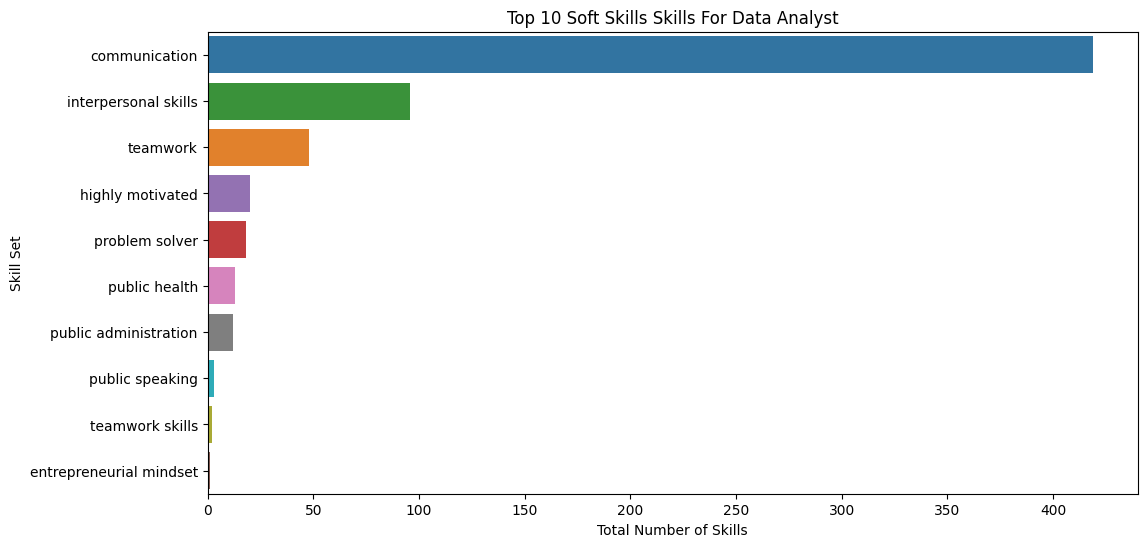

In [474]:
count_plot(df_analyst_ss,'fuzz_ss','Data Analyst','Soft Skills',10)

### Fx count plot
#### syntax : count_plt(df,subset,role,skill,top_skills)
1. df : Data Frame - dt :pandas
2. subset : column we want to subset - dt : str
3. role : role to be printed on the title - dt : str
4. skill : skill to be printed on the title - dt : str
5. top_skills : top number of skills we want to see - dt : int


## Data Scientist 

In [475]:
concatenated_df['Roles'].unique()

array(['Analyst', 'Big Data', 'AI', 'Engineer', 'Scientist',
       'Machine Learning'], dtype=object)

In [476]:
df_skill_data_scientist = role_skill_extract(concatenated_df,'Scientist')

## Data Skills

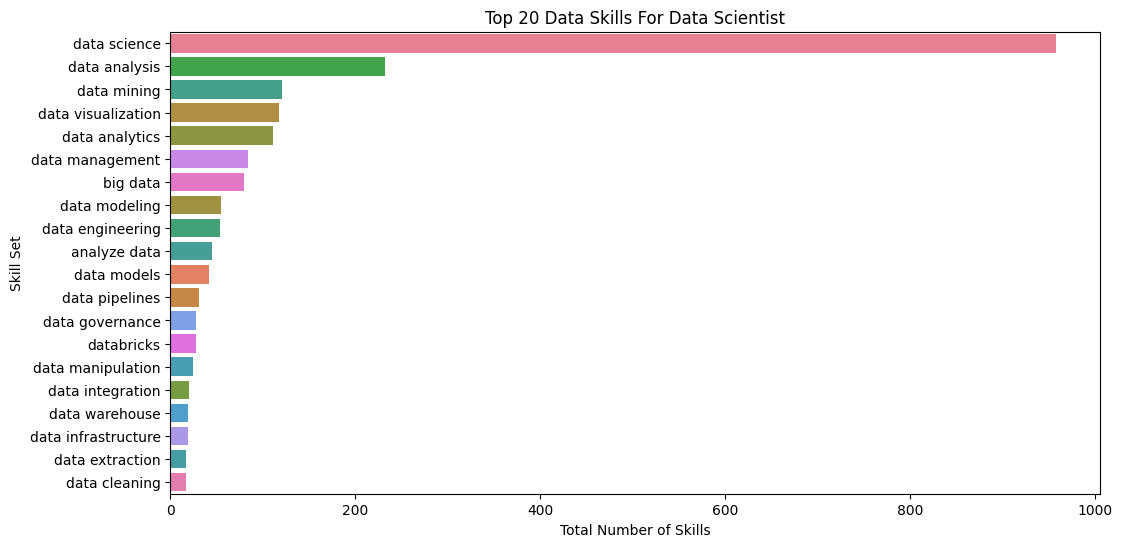

In [478]:
df_skill_data_scientist_data = df_skill_data_scientist[df_skill_data_scientist['fuzzy_skill'] == 'data']
count_plot(df_skill_data_scientist_data,'skill','Data Scientist','Data',20)

## Technology Skills

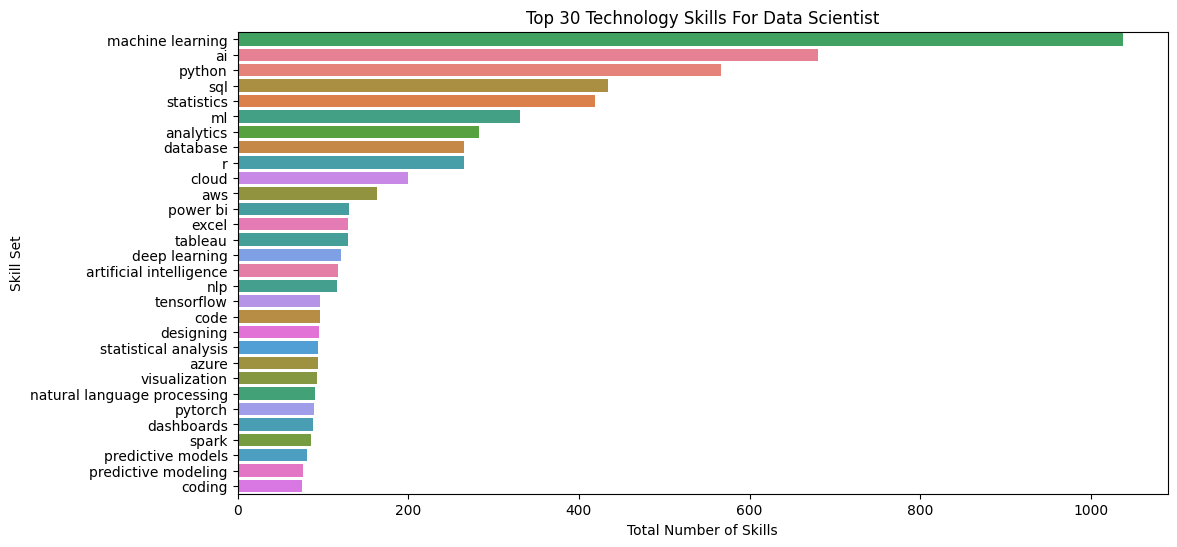

In [480]:
df_skill_data_scientist_tech = df_skill_data_scientist[df_skill_data_scientist['fuzzy_skill'] != 'data']
count_plot(df_skill_data_scientist_tech,'fuzzy_skill','Data Scientist','Technology',30)

## Soft Skills

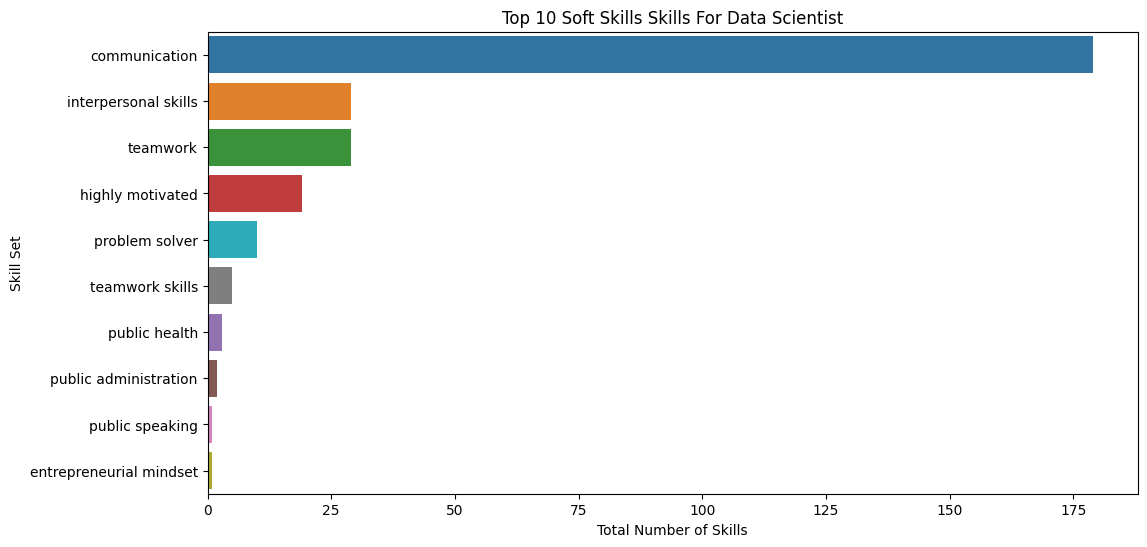

In [481]:
df_scientist_ss = role_soft_extract(concatenated_df,'Scientist')
count_plot(df_scientist_ss,'fuzz_ss','Data Scientist','Soft Skills',10)

## Machine Learning

### Data Skill

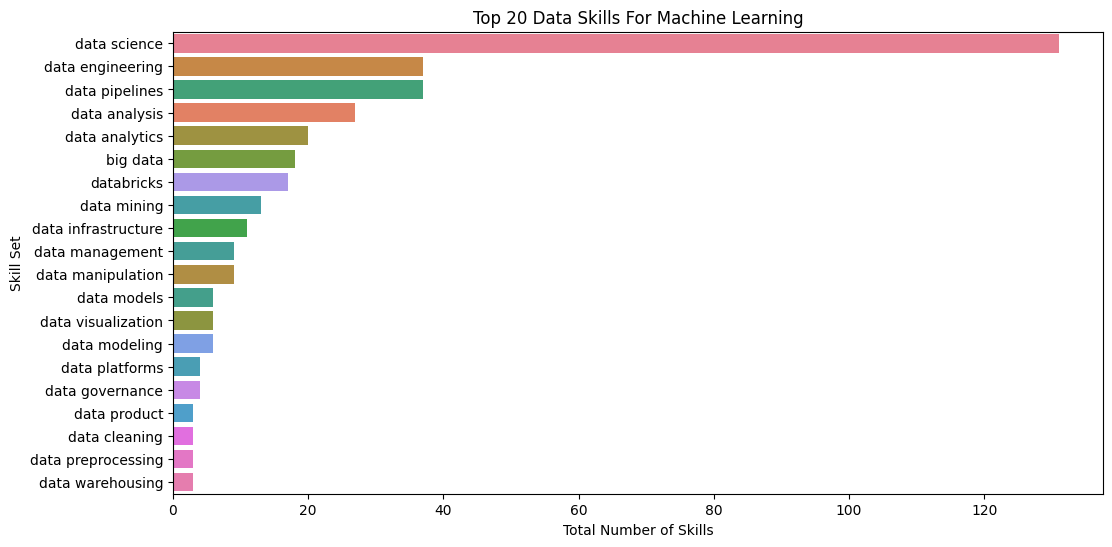

In [557]:
df_skill_data_ml = role_skill_extract(concatenated_df,'Machine Learning')
df_skill_data_ml_data = df_skill_data_ml[df_skill_data_ml['fuzzy_skill'] == 'data']
count_plot(df_skill_data_ml_data,'skill','Machine Learning','Data',20)

### Techology Skills

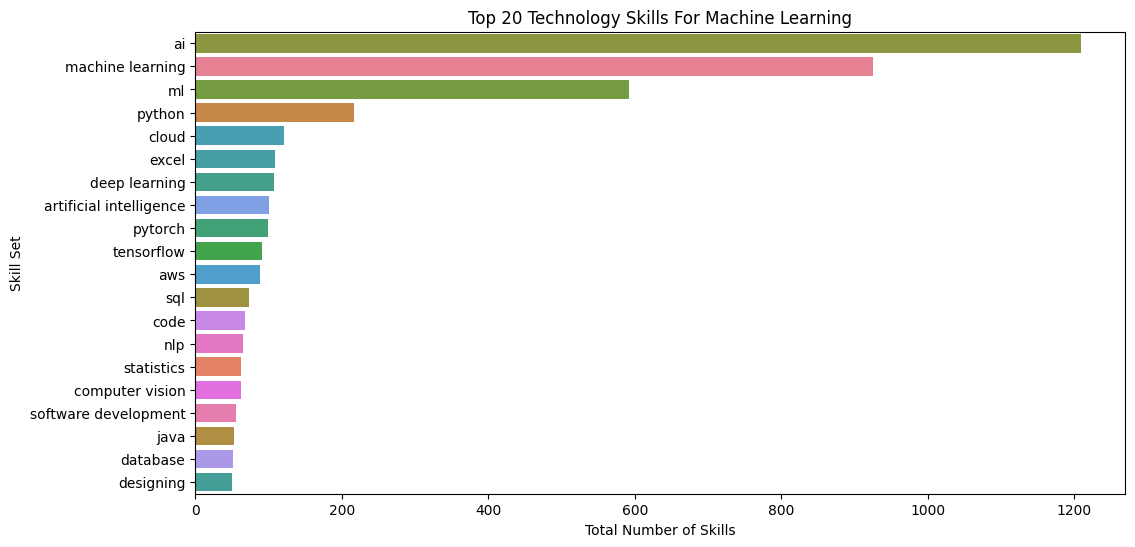

In [558]:
df_skill_data_ml_tech = df_skill_data_ml[df_skill_data_ml['fuzzy_skill'] != 'data']
count_plot(df_skill_data_ml_tech,'fuzzy_skill','Machine Learning','Technology',20)

### soft skills

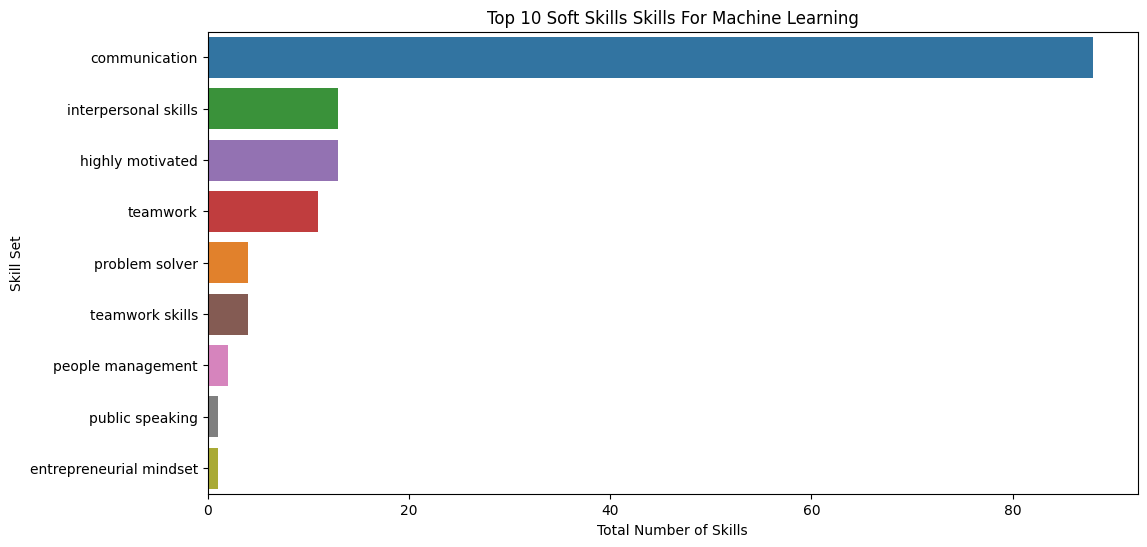

In [559]:
df_ml_ss = role_soft_extract(concatenated_df,'Machine Learning')
count_plot(df_ml_ss,'fuzz_ss','Machine Learning','Soft Skills',10)

### Data Engineer

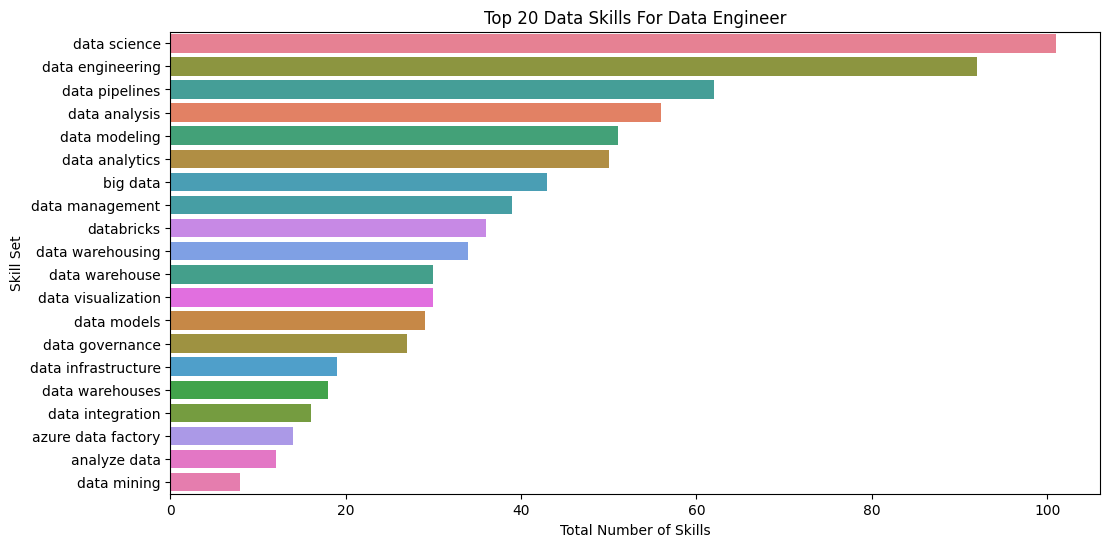

In [560]:
df_skill_data_eng = role_skill_extract(concatenated_df,'Engineer')
df_skill_data_eng_data = df_skill_data_eng[df_skill_data_eng['fuzzy_skill'] == 'data']
count_plot(df_skill_data_eng_data,'skill','Data Engineer','Data',20)

## Technology Skills

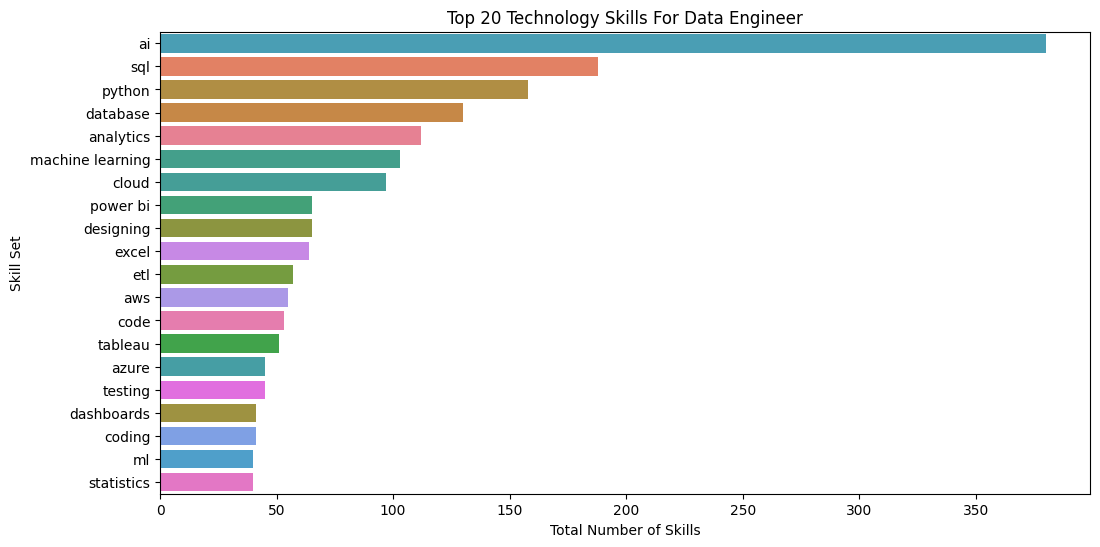

In [561]:
df_skill_data_eng_data = df_skill_data_eng[df_skill_data_eng['fuzzy_skill'] != 'data']
count_plot(df_skill_data_eng_data,'fuzzy_skill','Data Engineer','Technology',20)


### Salary Parsing

In [487]:
def salary_preprocessing(df,subset):
    def extract_salary(string):
        list = re.findall(r'\$\d+',string)
        return list

    def salary_list(list):
        if len(list) == 0:
            return np.nan
        elif len(list) == 1:
            salary = str(list[0]).replace('$','')
            return int(salary)
        else:
            salary = str(list[1]).replace('$','')
            return int(salary)
        
    def adjustments(value):
        if value < 200:
            salary = value*40*4*12
            return salary
        else:
            return value
        
    salary = df[subset]

    salary['new'] = salary['Salary'].apply(lambda x : str(x).replace(',',''))

    salary['extract_salary'] = salary['new'].apply(extract_salary)

    salary['salary_list'] = salary['extract_salary'].apply(salary_list)

    salary_drop_na = salary.dropna(subset='salary_list')

    salary_drop_na['hr_adjustments'] = salary_drop_na['salary_list'].apply(adjustments)
    
    return salary_drop_na

In [562]:
df_salary = salary_preprocessing(concatenated_df,['Salary','Roles'])

C:\Users\Karthi\AppData\Local\Temp\ipykernel_15368\4254786213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['new'] = salary['Salary'].apply(lambda x : str(x).replace(',',''))
C:\Users\Karthi\AppData\Local\Temp\ipykernel_15368\4254786213.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['extract_salary'] = salary['new'].apply(extract_salary)
C:\Users\Karthi\AppData\Local\Temp\ipykernel_15368\4254786213.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [489]:
df_salary

,Salary,Roles,new,extract_salary,salary_list,hr_adjustments
1,$65 - $70 an hour - Contract,Analyst,$65 - $70 an hour - Contract,"[$65, $70]",70.0,134400.0
2,"$75,600 - $172,000 a year - Full-time",Analyst,$75600 - $172000 a year - Full-time,"[$75600, $172000]",172000.0,172000.0
3,"$93,376.88 - $112,453.88 a year - Full-time",Analyst,$93376.88 - $112453.88 a year - Full-time,"[$93376, $112453]",112453.0,112453.0
4,"$62,698.24 - $146,949.00 a year - Full-time",Analyst,$62698.24 - $146949.00 a year - Full-time,"[$62698, $146949]",146949.0,146949.0
5,"$160,000 - $185,000 a year - Full-time",Analyst,$160000 - $185000 a year - Full-time,"[$160000, $185000]",185000.0,185000.0
...,...,...,...,...,...,...
3782,"$107,000 - $189,000 a year - Full-time",Machine Learning,$107000 - $189000 a year - Full-time,"[$107000, $189000]",189000.0,189000.0
3783,"$129,300 - $223,600 a year - Full-time",Machine Learning,$129300 - $223600 a year - Full-time,"[$129300, $223600]",223600.0,223600.0
3787,"$158,000 - $175,500 a year - Full-time",Machine Learning,$158000 - $175500 a year - Full-time,"[$158000, $175500]",175500.0,175500.0
3797,"$96,600 - $220,000 a year - Full-time",Machine Learning,$96600 - $220000 a year - Full-time,"[$96600, $220000]",220000.0,220000.0


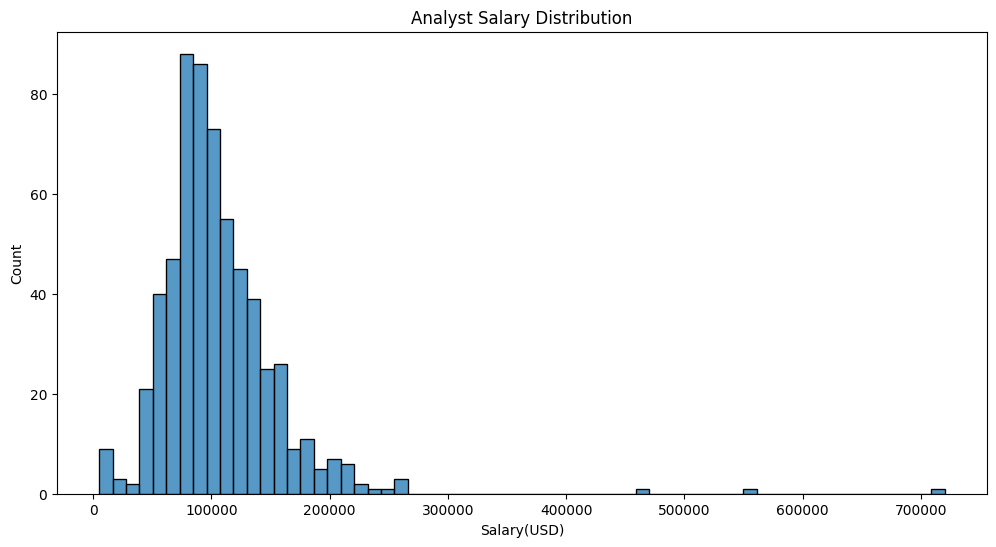

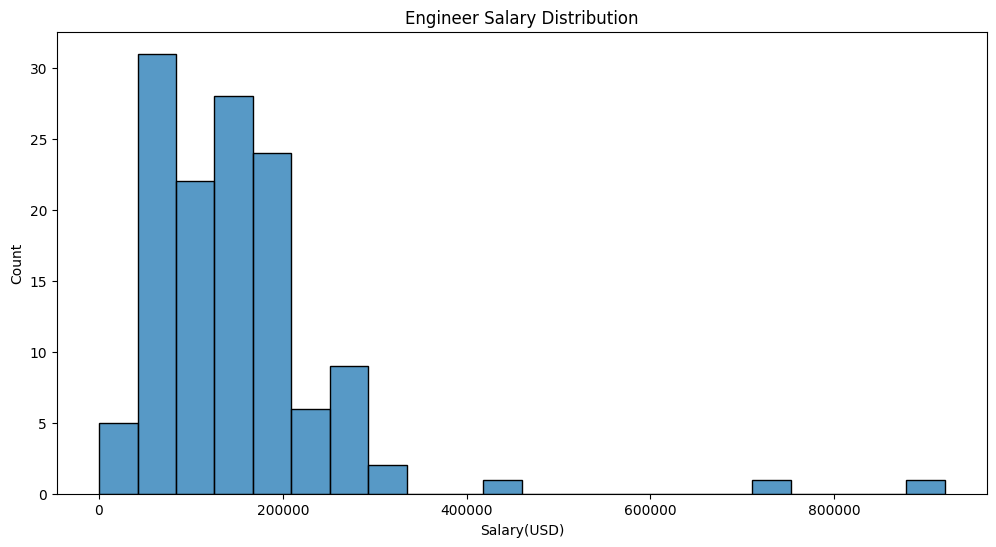

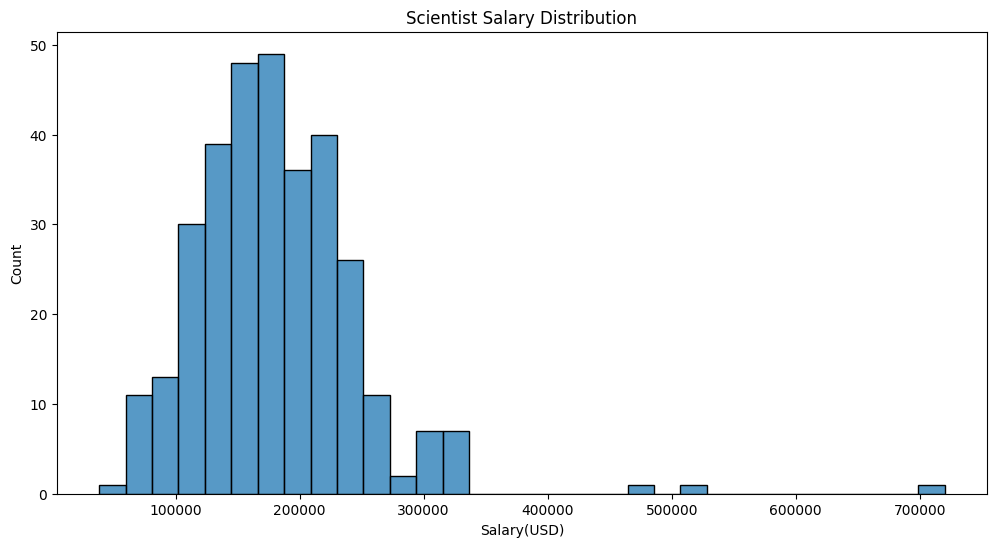

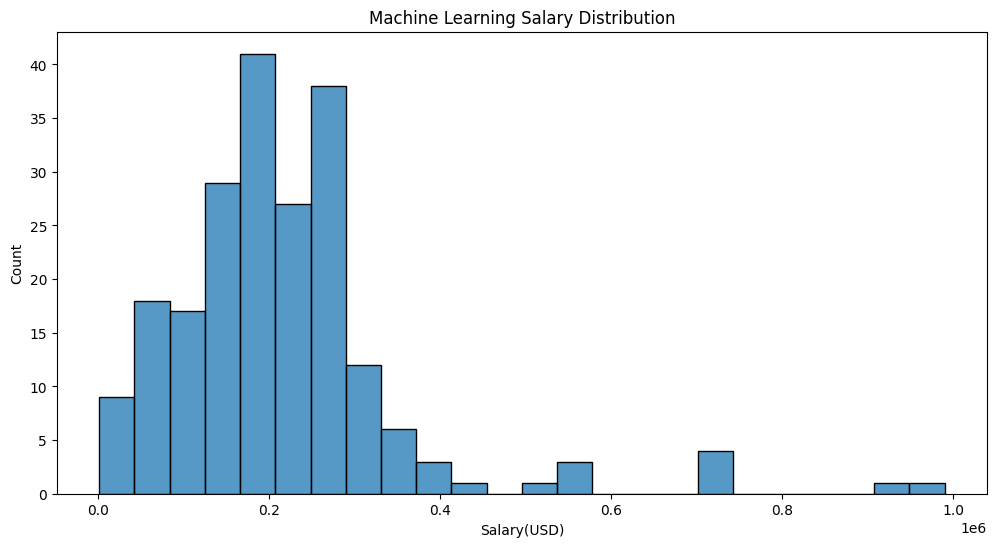

In [563]:
unique_role = df_salary['Roles'].unique()
for role in unique_role:
    df_role = df_salary[df_salary['Roles'] == role]
    plt.figure(figsize=(12, 6))
    sns.histplot(data = df_role,
                 x = 'hr_adjustments')
    plt.title(f'{role} Salary Distribution')
    plt.xlabel('Salary(USD)')
    plt.ylabel('Count')
    plt.show()

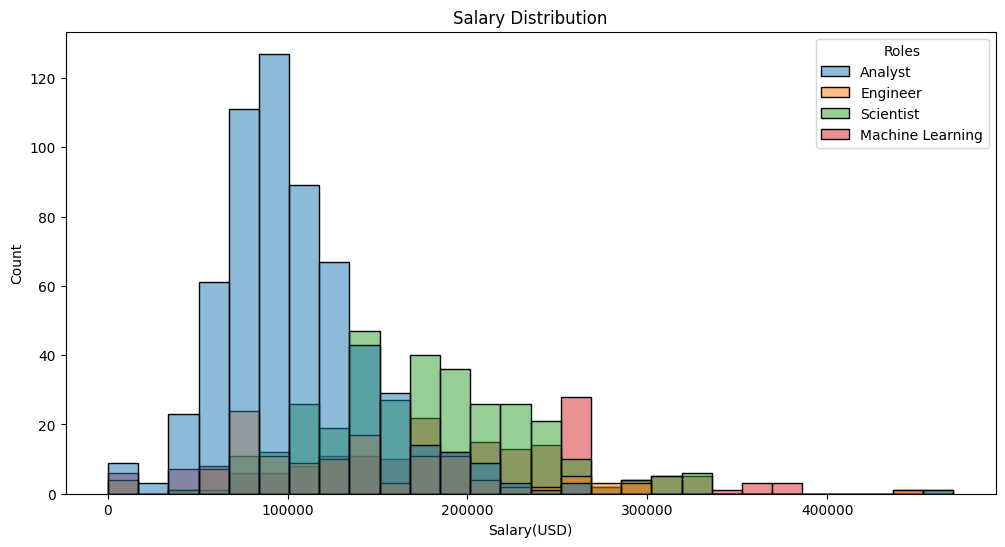

In [564]:
df_salary_1 = df_salary[df_salary['hr_adjustments'] < 500000]
plt.figure(figsize=(12, 6))
sns.histplot(data = df_salary_1, x = 'hr_adjustments', hue = 'Roles')
plt.xlabel('Salary(USD)')
plt.title('Salary Distribution')
plt.show()

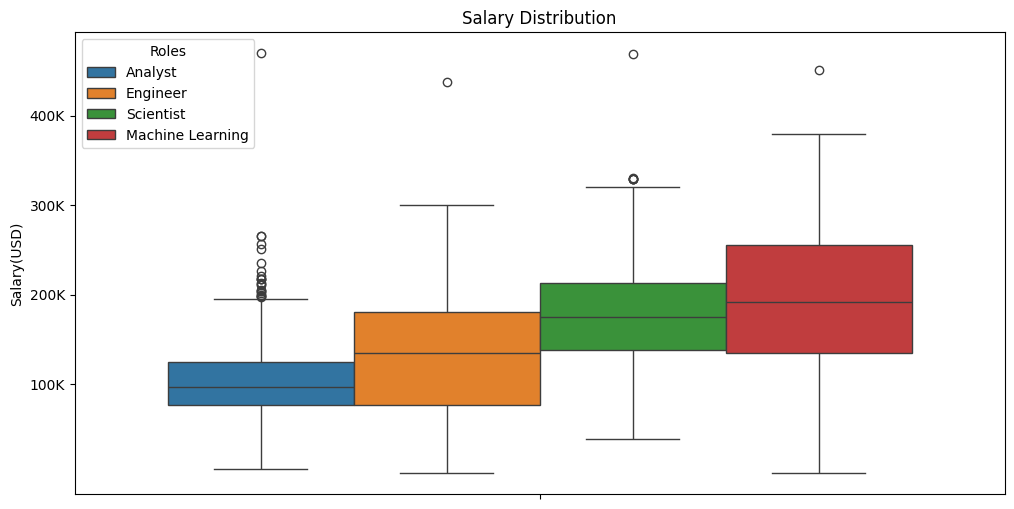

In [566]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df_salary_1,y = 'hr_adjustments' , hue='Roles')
plt.yticks([100000,200000,300000,400000],['100K','200K','300K','400K'])
plt.ylabel('Salary(USD)')
plt.title('Salary Distribution')
plt.show()

In [567]:
def skill_extract_df(df):
    #df = df[df['Roles'] == subset]
    SKILLS = []
    DATA_TOOLS = []
    EDUCATION = []
    EXPERIENCE = []
    SOFT_SKILLS = []
    DOMAIN = []
    RESPONSIBILITY = []
    CERTIFICATE = []
    SALARY = []
    OTHERS = []
    dic_extract = {}
    for text in df['Description']:
        doc = nlp_job_ner(text)
        for ent in doc.ents:
            if ent.label_ == 'SKILLS':
                SKILLS.append(ent.text)
            elif ent.label_ == 'DATA TOOLS':
                DATA_TOOLS.append(ent.text)
            elif ent.label_ == 'EDUCATION':
                EDUCATION.append(ent.text)
            elif ent.label_ == 'EXPERIENCE':
                EXPERIENCE.append(ent.text)
            elif ent.label_ == 'SOFT-SKILLS':
                SOFT_SKILLS.append(ent.text)
            elif ent.label_ == 'DOMAIN':
                DOMAIN.append(ent.text)
            elif ent.label_ == 'RESPONSIBILITY':
                RESPONSIBILITY.append(ent.text)
            elif ent.label_ == 'CERTIFICATE':
                CERTIFICATE.append(ent.text)
            elif ent.label_ == 'SALARY':
                SALARY.append(ent.text)
            else:
                OTHERS.append(ent.text)
                
    dic_extract = {
            'SKILLS': SKILLS,
            'DATA_TOOLS':DATA_TOOLS,
            'EDUCATION':EDUCATION,
            'EXPERIENCE':EXPERIENCE,
            'SOFT_SKILLS':SOFT_SKILLS,
            'DOMAIN':DOMAIN,
            'RESPONSIBILITY':RESPONSIBILITY,
            'CERTIFICATE':CERTIFICATE,
            'SALARY':SALARY,
            'OTHERS':OTHERS
        }
    return dic_extract

In [568]:
extract_all_role = skill_extract_df(concatenated_df)

In [574]:
skill_set  = ['SKILLS',
            'DATA_TOOLS',
            'EDUCATION',
            'EXPERIENCE',
            'SOFT_SKILLS',
            'DOMAIN',
            'RESPONSIBILITY',
            'CERTIFICATE',
            'SALARY',
            'OTHERS']
length ={}
for skill in skill_set:
    length[skill] = len(extract_all_role[skill])


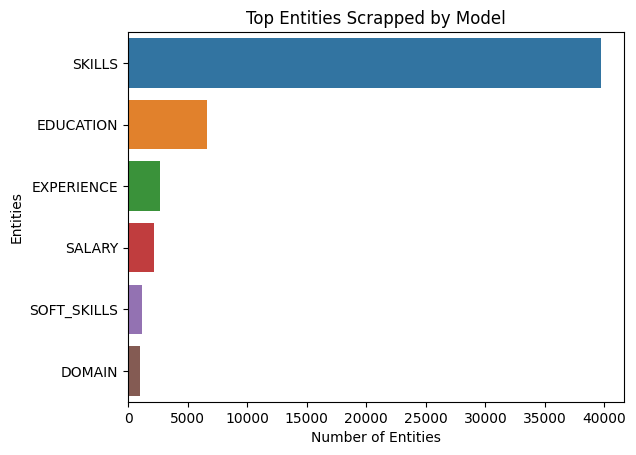

In [592]:
skill_count = pd.DataFrame(length.items(),columns=['Skill','Count'])
skill_count = skill_count.sort_values(by = 'Count', ascending= False)[0:6]
sns.barplot(data = skill_count , y = 'Skill', x ='Count',hue = 'Skill')
plt.title('Top Entities Scrapped by Model')
plt.ylabel('Entities')
plt.xlabel('Number of Entities')
plt.show()